# $\text{Dependencies}$

In [ ]:
import QuantumResourcesTCI as QRT

import ITensors as IT
import ITensorMPS as ITM

using ProgressMeter
using CSV,HDF5,DataFrames
using GLMakie

# $\text{Non-Stabilizerness}$ 

The Stabilizer Rényi-$2$ Entropy (SRE) is defined for a pure state $\ket{\psi}$ as
$$
\mathcal{M}_2(\ket{\psi}) \equiv  - \log_2 \left(\dfrac{1}{2^L}\sum_P \langle |\psi\rangle P |\psi\rangle^4\right)
$$
where the sum runs on all the Pauli strings $P=\bigotimes_{j=1}^L P_j$, with $P_j \in \left\lbrace \mathbb{1}, X, Y, Z\right\rbrace$, and $X,Y,Z$ are the Pauli matrices.

In [6]:
N = 5

sites = IT.siteinds("S=1/2", N)  
psi = ITM.random_mps(sites, linkdims=2)
ops_array = QRT.precompute_pauli_ops(sites)
phi = ITM.MPS(sites)

func(str) = QRT.get_scalar_magic(psi, phi, ops_array, str)

localdims = fill(4, N)
allindices = [getindex.(Ref(i), 1:N) for i in CartesianIndices(Tuple(localdims))];

exact_value = N-log2(sum(func.(allindices)))

tci_magic, tci, ranks, errors = QRT.get_quantum_magic(psi, tolerance=1e-6, maxdim=20)#, tci_path = "TCI_MPS.h5")

println("Exact value: $(exact_value)")
println("TCI approximation: $(tci_magic)")
println("Ranks : $(ranks)")

Exact value: 1.3305944732711898
TCI approximation: 1.3305943312293609
Ranks : [9, 9, 9]


# $\text{1D Ising Model} $ 

For the $|\psi\rangle$ we choose the ground state of the 1D FM transverse-field Ising chain.

$$ \mathcal{H}=-\sum_{j=1}^{L}Z_j Z_{j+1}-h\sum_{j=1}^{L}X_j $$

assuming periodic boundary condition, hence $Z_{L+1} = Z_L$

# $\text{Example for }L = 8$ 

In [10]:
N = 8

path = "./data_test/N_$(N)/"
mkpath(path)

path_mps = "./data_test/N_$(N)/MPS_GS/"
mkpath(path_mps)

J = -1.0
h_values = 0.01:0.1:2.01
verbose = 0
periodic=true

print("ready")

ready

In [11]:
@showprogress Threads.@threads  for i in eachindex(h_values)
    
    h = h_values[i]
    groundstate, energy, bondim = QRT.run_Ising_1D_DMRG(N,J,h,verbose,periodic)

    f = h5open(path_mps * "/GS_Ising_N_$(N)_J_$(J)_h_$(h).h5","w")
    write(f,"psi", groundstate)
    close(f)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


In [12]:
magic_results = Vector{Any}(undef, length(h_values))
@showprogress for i in eachindex(h_values)
    h = h_values[i]

    psi_file = path_mps * "GS_Ising_N_$(N)_J_$(J)_h_$(h).h5"
    tci_path = path_mps * "TCI_Ising_N_$(N)_J_$(J)_h_$(h).h5"
    
    f = h5open(psi_file, "r")
    psi = read(f, "psi", ITM.MPS)
    close(f)

    # Compute coherence
    magic, tci, ranks, errors = QRT.get_quantum_magic(psi, tolerance=1e-6, maxdim=20, output=0)
    magic_results[i] = magic

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


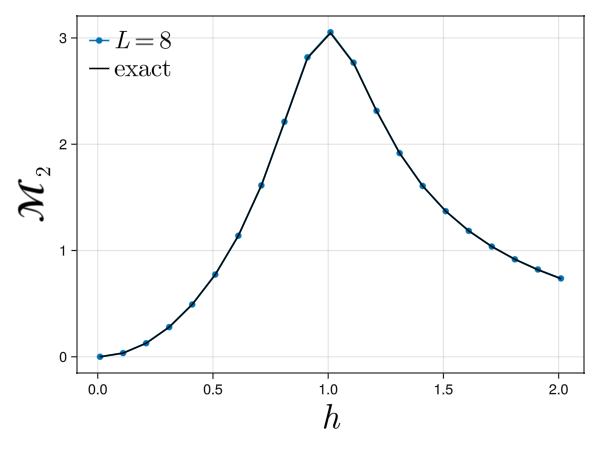

In [13]:
df = CSV.read("exact_magic_N8.csv", DataFrame)

fig = Figure()

ax = Axis(fig[1, 1], xlabel = L"$h$", ylabel = L"\mathcal{M}_{2}",xlabelsize = 35, ylabelsize = 35)

scatterlines!(ax, h_values, magic_results, label = L"$L=%$(N)$")

lines!(ax, df.h, df.Magic, label = L"$\text{exact}$", color="black")

axislegend(framevisible = false, position = :lt, labelsize=25)
fig

# $\text{Quantum Coherence}$

The Relative Entropy of Coherence (REC) for a density matrix $\rho$ is defined as
$$
\mathcal{C}(\rho) \equiv \mathcal{S}(\rho_{\textrm{diag}}) - \mathcal{S}(\rho)
$$
where $\mathcal{S}(\rho)$ denotes the von Neumann entropy, and $\rho_{\textrm{diag}}$ is the diagonal matrix obtained by setting the off-diagonal elements of $\rho$ to zero.

Since we are considering pure states, $\mathcal{S}(\rho) = 0$, and the expression simplifies to
$$
    \mathcal{C}(|\psi\rangle) = \sum_{i=1}^{2^L} c_i^2 \log_2 c_i^2.
$$
Here, $c_i$ are the coefficients of the state $\ket{\psi} = \sum_{i=1}^{2^N} c_i \ket{i}$ in the chosen basis $\{\ket{i}\}_{i=1}^{2^L}$.

In [16]:
N = 5

sites = IT.siteinds("S=1/2", N)  
psi = ITM.random_mps(sites, linkdims=2)

sites = IT.siteinds(psi)
N = length(psi)
func(str) = QRT.get_scalar_entropy(psi, sites, str)

localdims = fill(2, N)
allindices = [getindex.(Ref(i), 1:N) for i in CartesianIndices(Tuple(localdims))];

exact_value = sum(func.(allindices))

tci_coherence, tci, ranks, errors = QRT.get_quantum_coherence(psi, tolerance=1e-6, maxdim=20)#, tci_path = "TCI_MPS.h5")

println("Exact value: $(exact_value)")
println("TCI approximation: $(tci_coherence)")
println("Ranks : $(ranks)")

Exact value: 2.5472185185606486
TCI approximation: 2.547218518560648
Ranks : [4, 4, 4]


# $\text{2D Ising Model} $ 

The state $|\psi\rangle$ is taken to be the ground state of 2D Ising Model

$$ \mathcal{H} = - \sum_{\langle i,j \rangle} Z_i Z_j - h \sum_i X_i, $$

where the first summation runs over nearest-neighbor pairs, and periodic boundary conditions (PBCs) are assumed.

# $\text{Example for }L= 3 \times 3$ 

In [20]:
using Base.Threads

Nx = 3
Ny = 3

path = "./data_test/Nx_$(Nx)_Ny_$(Ny)/"
mkpath(path)

path_mps = "./data_test/Nx_$(Nx)_Ny_$(Ny)/MPS_GS/"
mkpath(path_mps)

J = -1.0
h_values = 0.01:0.1:5.01
verbose = 0
periodic=true

@showprogress Threads.@threads  for i in eachindex(h_values)
    h = h_values[i]
    groundstate, energy, bondim = QRT.run_Ising_2D_DMRG(Nx, Ny, J, h, verbose,periodic)

    f = h5open(path_mps * "/GS_Ising_2D_Nx_$(Nx)_Ny_$(Ny)_J_$(J)_h_$(h).h5","w")
    write(f,"psi", groundstate)
    close(f)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [21]:
coherence_results = Vector{Any}(undef, length(h_values))
@showprogress for i in eachindex(h_values)
    h = h_values[i]

    psi_file = path_mps * "GS_Ising_2D_Nx_$(Nx)_Ny_$(Ny)_J_$(J)_h_$(h).h5"
    tci_path = path_mps * "TCI_Ising_2D_Nx_$(Nx)_Ny_$(Ny)_J_$(J)_h_$(h).h5"

    f = h5open(psi_file, "r")
    psi = read(f, "psi", ITM.MPS)
    close(f)

    # Compute coherence
    coherence, tci, ranks, errors = QRT.get_quantum_coherence(psi, tolerance=1e-6, maxdim=40, output=0)
    coherence_results[i] = coherence

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


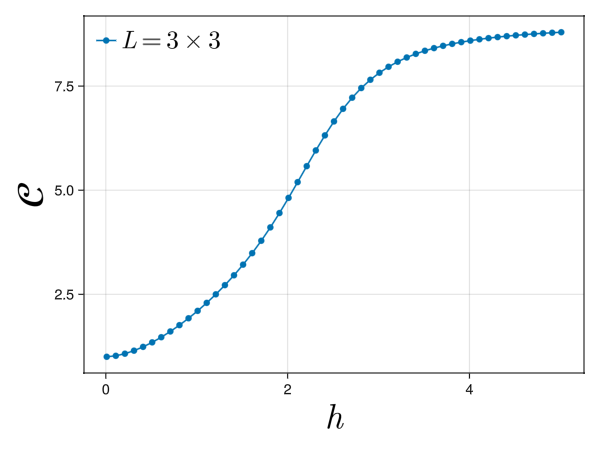

In [22]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = L"$h$", ylabel = L"\mathcal{C}",xlabelsize = 35, ylabelsize = 35)

scatterlines!(ax, h_values, coherence_results, label = L"$L=%$(Nx)\times %$(Ny)$")

axislegend(framevisible = false, position = :lt, labelsize=25)

fig